In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import stats
import math
import seaborn as sns
%matplotlib inline

In [2]:
ps = pd.read_csv('patch_seq_log_mouse.csv')

In [3]:
ps = ps[["Date", "User", "Post patch?", "Post patch pipette R", "Nucleus sucked in?", "Notes", "Internal version", "Picogreen", "Ratio", "PCR cycles", "SM_QC_PF"]]
ps.dropna(subset = ["Post patch?", "Picogreen"], inplace = True)
ps["User"] = ps["User"].astype("category")
ps["Post patch?"] = ps["Post patch?"].astype("category")
ps["SM_QC_PF"] = ps["SM_QC_PF"].astype("category")
ps = ps[ps["SM_QC_PF"] != "cnt"]
ps = ps[ps["PCR cycles"] == 21]
ps["Date"] = pd.to_datetime(ps["Date"], format = '%y%m%d')
ps
#ps['Post patch?'].value_counts()

,Date,User,Post patch?,Post patch pipette R,Nucleus sucked in?,Notes,Internal version,Picogreen,Ratio,PCR cycles,SM_QC_PF
4968,2017-04-19,P2,Outside-Out,NaN,NaN,NaN,AiV2,71,0.41,21.0,fail
4969,2017-04-19,P2,Outside-Out,NaN,NaN,NaN,AiV2,608,0.54,21.0,pass
4970,2017-04-19,P2,No-Seal,NaN,NaN,NaN,AiV2,6,1,21.0,fail
4971,2017-04-19,P2,Nucleated,NaN,NaN,NaN,AiV2,1536,0.71,21.0,pass
4972,2017-04-19,P2,Outside-Out,NaN,NaN,NaN,AiV2,582,0.55,21.0,pass
4973,2017-04-19,P2,Nucleated,NaN,NaN,NaN,AiV2,1154,0.81,21.0,pass
4974,2017-04-19,P2,No-Seal,NaN,NaN,NaN,AiV2,1504,0.59,21.0,pass
4975,2017-04-19,P2,Nucleated,NaN,NaN,NaN,AiV2,1330,0.71,21.0,pass
4978,2017-04-19,P6,No-Seal,NaN,NaN,NaN,AiV2,839,0.33,21.0,fail
4979,2017-04-19,P6,No-Seal,NaN,NaN,NaN,AiV2,1292,0.51,21.0,pass


In [4]:
ps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1847 entries, 4968 to 7596
Data columns (total 11 columns):
Date                    1847 non-null datetime64[ns]
User                    1847 non-null category
Post patch?             1847 non-null category
Post patch pipette R    240 non-null float64
Nucleus sucked in?      240 non-null object
Notes                   1728 non-null object
Internal version        1841 non-null object
Picogreen               1847 non-null object
Ratio                   1846 non-null object
PCR cycles              1847 non-null float64
SM_QC_PF                1847 non-null category
dtypes: category(3), datetime64[ns](1), float64(2), object(5)
memory usage: 136.2+ KB


In [5]:
def get_count(x):    
    count = x["Post patch?"].count()
    return count

def calc_pct(part,total):
    pct = float(get_count(part)) / get_count(total)
    return pct

In [6]:
def nucleated(x):
    nucleus = x[(x["Post patch?"] == "Nucleated") | (((x["Post patch?"] == "nucleus_visible") | (x["Post patch?"] == "nucleus_present")) & (x["Post patch pipette R"] >= 501))]
    return nucleus

def partial_nucleated(y):
    partial = y[(y["Post patch?"] == 'Partial-Nucleus') | (((y['Post patch?'] == 'nucleus_present') | (y['Post patch?'] == 'nucleus_visible')) & (y["Post patch pipette R"] <= 500))]
    return partial

def outside_out(z):
    outside = z[(z["Post patch?"] == 'Outside-Out') | (((z['Post patch?'] == 'nucleus_absent') | (z['Post patch?'] == 'no_nuclues_visible')) & (z['Post patch pipette R'] >= 501))]
    return outside

def no_seal(w): 
    no = w[(w["Post patch?"] == 'No-Seal') | (((w['Post patch?'] == 'nucleus_absent') | (w['Post patch?'] == 'no_nucleus_visible')) & (w['Post patch pipette R'] <= 500))]
    return no
    
def entire_cell(v):
    entire = v[(v["Post patch?"] == 'Entire-Cell') | (v['Post patch?'] == 'entire_cell')]
    return entire
    
def pass_only(df):
    pas = df[df["SM_QC_PF"] == "pass"]
    return pas

def gen_filter(df, col, cond):
    filtr = df[df[col] == cond]
    return filtr

In [7]:
nuc = nucleated(ps)
nuc["post patch class"] = "Nucleated"

part_nuc = partial_nucleated(ps)
part_nuc["post patch class"] = "Partial nucleated"

out_out = outside_out(ps)
out_out["post patch class"] = "Outisde out"

noSeal = no_seal(ps)
noSeal["post patch class"] = "No seal"

entirecell = entire_cell(ps)
entirecell["post patch class"] = "Entire Cell"

frames = [nuc, part_nuc, out_out, noSeal, entirecell]
ps2 = pd.concat(frames)
ps2

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#

,Date,User,Post patch?,Post patch pipette R,Nucleus sucked in?,Notes,Internal version,Picogreen,Ratio,PCR cycles,SM_QC_PF,post patch class
4971,2017-04-19,P2,Nucleated,NaN,NaN,NaN,AiV2,1536,0.71,21.0,pass,Nucleated
4973,2017-04-19,P2,Nucleated,NaN,NaN,NaN,AiV2,1154,0.81,21.0,pass,Nucleated
4975,2017-04-19,P2,Nucleated,NaN,NaN,NaN,AiV2,1330,0.71,21.0,pass,Nucleated
4988,2017-04-20,P1,Nucleated,NaN,NaN,NaN,AiV2,890,0.66,21.0,pass,Nucleated
4997,2017-04-20,P1,Nucleated,NaN,NaN,NaN,AiV2,1023,0.65,21.0,pass,Nucleated
5009,2017-04-20,P2,Nucleated,NaN,NaN,NaN,AiV2,1701,0.74,21.0,pass,Nucleated
5022,2017-04-21,P1,Nucleated,NaN,NaN,"Fluorescence in Pipette,Cell Dimmed",AiV2,1211,0.81,21.0,pass,Nucleated
5026,2017-04-21,P2,Nucleated,NaN,NaN,Fluorescence in Pipette,AiV2,1272,0.61,21.0,pass,Nucleated
5027,2017-04-21,P2,Nucleated,NaN,NaN,Fluorescence in Pipette,AiV2,775,0.75,21.0,pass,Nucleated
5035,2017-04-21,P2,Nucleated,NaN,NaN,NaN,AiV2,1134,0.78,21.0,pass,Nucleated


In [8]:
ps2["Picogreen"] = pd.to_numeric(ps2["Picogreen"].str.replace(' ',''), errors ='force')
ps2["post patch class"] = ps2["post patch class"].astype("category")
ps2['Internal version'] = ps2['Internal version'].astype('category')
ps2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1845 entries, 4971 to 7588
Data columns (total 12 columns):
Date                    1845 non-null datetime64[ns]
User                    1845 non-null category
Post patch?             1845 non-null category
Post patch pipette R    239 non-null float64
Nucleus sucked in?      239 non-null object
Notes                   1726 non-null object
Internal version        1839 non-null category
Picogreen               1845 non-null float64
Ratio                   1844 non-null object
PCR cycles              1845 non-null float64
SM_QC_PF                1845 non-null category
post patch class        1845 non-null category
dtypes: category(5), datetime64[ns](1), float64(3), object(3)
memory usage: 125.6+ KB


In [9]:
ps2 = ps2[ps2["Picogreen"] < 10000]
ps2 = ps2[ps2['Internal version'] != 'AiV2-50uM alexa 489']
ps2['Internal version'].value_counts()

AiV2                   1368
AiV2-50uM alexa 488     469
Name: Internal version, dtype: int64

In [ ]:
#Internal = ps2.groupby(['Internal version'])
#standard = ps2[ps2['Internal version'] == 'AiV2']
#standard
sns.swarmplot(x='Internal version', y='Picogreen', data=ps2)
#sns.violinplot(x='post patch class', y='Picogreen', data=ps2)

In [ ]:
sns.violinplot(x='Internal version', y='Picogreen', data=ps2, scale='area')
plt.title("Picogreen Concentration vs Internal Version")
plt.savefig("Picogreen Concentration vs Internal Version", dpi=300)

In [ ]:
#scatterplot data includes both standard and Alexa internal
sns.swarmplot(x='post patch class', y='Picogreen', data=ps2)

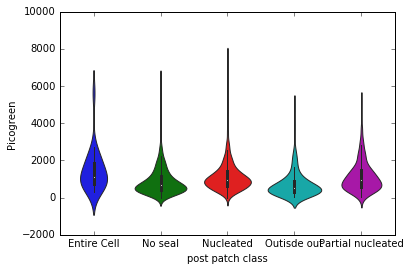

In [13]:
#violinplot data includes both standard and Alexa internal
sns.violinplot(x='post patch class', y='Picogreen', data=ps2)

In [14]:
standard_internal = gen_filter(ps2,"Internal version", "AiV2")
standard_internal

,Date,User,Post patch?,Post patch pipette R,Nucleus sucked in?,Notes,Internal version,Picogreen,Ratio,PCR cycles,SM_QC_PF,post patch class
4971,2017-04-19,P2,Nucleated,NaN,NaN,NaN,AiV2,1536.0,0.71,21.0,pass,Nucleated
4973,2017-04-19,P2,Nucleated,NaN,NaN,NaN,AiV2,1154.0,0.81,21.0,pass,Nucleated
4975,2017-04-19,P2,Nucleated,NaN,NaN,NaN,AiV2,1330.0,0.71,21.0,pass,Nucleated
4988,2017-04-20,P1,Nucleated,NaN,NaN,NaN,AiV2,890.0,0.66,21.0,pass,Nucleated
4997,2017-04-20,P1,Nucleated,NaN,NaN,NaN,AiV2,1023.0,0.65,21.0,pass,Nucleated
5009,2017-04-20,P2,Nucleated,NaN,NaN,NaN,AiV2,1701.0,0.74,21.0,pass,Nucleated
5022,2017-04-21,P1,Nucleated,NaN,NaN,"Fluorescence in Pipette,Cell Dimmed",AiV2,1211.0,0.81,21.0,pass,Nucleated
5026,2017-04-21,P2,Nucleated,NaN,NaN,Fluorescence in Pipette,AiV2,1272.0,0.61,21.0,pass,Nucleated
5027,2017-04-21,P2,Nucleated,NaN,NaN,Fluorescence in Pipette,AiV2,775.0,0.75,21.0,pass,Nucleated
5035,2017-04-21,P2,Nucleated,NaN,NaN,NaN,AiV2,1134.0,0.78,21.0,pass,Nucleated


In [15]:
standard_internal['post patch class'].value_counts()

Nucleated            596
No seal              495
Partial nucleated    177
Outisde out           88
Entire Cell           12
dtype: int64

In [16]:
standard_nucleated = gen_filter(standard_internal,"post patch class", "Nucleated")
standard_nucleated.mean()

Post patch pipette R            NaN
Picogreen               1092.446309
PCR cycles                21.000000
dtype: float64

In [17]:
standard_partial = gen_filter(standard_internal,"post patch class", "Partial nucleated")
standard_partial.mean()

Post patch pipette R           NaN
Picogreen               1046.19209
PCR cycles                21.00000
dtype: float64

In [18]:
standard_noseal = gen_filter(standard_internal,"post patch class", "No seal")
standard_noseal.mean()

Post patch pipette R           NaN
Picogreen               882.553535
PCR cycles               21.000000
dtype: float64

In [20]:
standard_out = gen_filter(standard_internal,"post patch class", "Outisde out")
standard_out.mean()

Post patch pipette R           NaN
Picogreen               637.590909
PCR cycles               21.000000
dtype: float64

In [19]:
standard_entire = gen_filter(standard_internal,"post patch class", "Entire Cell")
standard_entire.mean()

Post patch pipette R       NaN
Picogreen               1681.0
PCR cycles                21.0
dtype: float64

In [22]:
alexa_internal = gen_filter(ps2,"Internal version", "AiV2-50uM alexa 488")
alexa_internal

,Date,User,Post patch?,Post patch pipette R,Nucleus sucked in?,Notes,Internal version,Picogreen,Ratio,PCR cycles,SM_QC_PF,post patch class
7108,2017-08-31,P2,Nucleated,NaN,NaN,No Bubbles 0.1 units of pressure on expulsion,AiV2-50uM alexa 488,927.0,0.75,21.0,pass,Nucleated
7109,2017-08-31,P2,Nucleated,NaN,NaN,Fluorescence in Pipette No Bubbles 0.1 units o...,AiV2-50uM alexa 488,844.0,0.74,21.0,pass,Nucleated
7110,2017-08-31,P2,Nucleated,NaN,NaN,Fluorescence in Pipette No Bubbles 0.1 units o...,AiV2-50uM alexa 488,637.0,0.69,21.0,pass,Nucleated
7113,2017-08-31,P8,Nucleated,NaN,NaN,"Fluorescence in Pipette,Cell Dimmed,Cell Shrun...",AiV2-50uM alexa 488,1187.0,0.71,21.0,pass,Nucleated
7116,2017-08-31,P8,Nucleated,NaN,NaN,"Fluorescence in Pipette,Cell Dimmed,Cell Shrun...",AiV2-50uM alexa 488,989.0,0.83,21.0,pass,Nucleated
7118,2017-08-31,P8,Nucleated,NaN,NaN,"Fluorescence in Pipette,Cell Dimmed,Cell Shrun...",AiV2-50uM alexa 488,946.0,0.71,21.0,pass,Nucleated
7119,2017-08-31,P8,Nucleated,NaN,NaN,"Fluorescence in Pipette,Cell Dimmed,Cell Shrun...",AiV2-50uM alexa 488,936.0,0.65,21.0,pass,Nucleated
7126,2017-09-01,P2,Nucleated,NaN,NaN,Fluorescence in Pipette Small Bubbles 0.1 unit...,AiV2-50uM alexa 488,659.0,0.7,21.0,pass,Nucleated
7128,2017-09-01,P2,Nucleated,NaN,NaN,Fluorescence in Pipette No Bubbles alexa inter...,AiV2-50uM alexa 488,1415.0,0.63,21.0,pass,Nucleated
7133,2017-09-01,P8,Nucleated,NaN,NaN,Fluorescence in Pipette No Bubbles nucleus may...,AiV2-50uM alexa 488,859.0,0.71,21.0,pass,Nucleated


In [23]:
alexa_internal['post patch class'].value_counts()

Nucleated            243
No seal              143
Partial nucleated     53
Outisde out           22
Entire Cell            8
dtype: int64

In [24]:
alexa_nucleated = gen_filter(alexa_internal,"post patch class", "Nucleated")
alexa_nucleated.mean()

Post patch pipette R    1471.755102
Picogreen               1299.827160
PCR cycles                21.000000
dtype: float64

In [25]:
alexa_partial = gen_filter(alexa_internal,"post patch class", "Partial nucleated")
alexa_partial.mean()

Post patch pipette R     137.886667
Picogreen               1333.769811
PCR cycles                21.000000
dtype: float64

In [26]:
alexa_noseal = gen_filter(alexa_internal,"post patch class", "No seal")
alexa_noseal.mean()

Post patch pipette R     72.210345
Picogreen               973.888112
PCR cycles               21.000000
dtype: float64

In [27]:
alexa_out = gen_filter(alexa_internal,"post patch class", "Outisde out")
alexa_out.mean()

Post patch pipette R    1194.444444
Picogreen               1090.090909
PCR cycles                21.000000
dtype: float64

In [28]:
alexa_entire = gen_filter(alexa_internal,"post patch class", "Entire Cell")
alexa_entire.mean()

Post patch pipette R      26.4000
Picogreen               1010.3125
PCR cycles                21.0000
dtype: float64

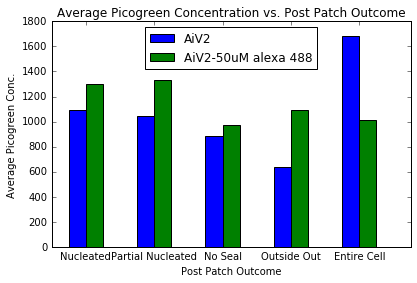

In [51]:
n_groups = 5

standard = [1092.446309, 1046.19209, 882.553535, 637.590909, 1681.0]
alexa = [1301.132780, 1333.769811, 973.888112, 1090.090909, 1010.3125]
index = np.arange(n_groups)
#index = [1,2,3,4,5]
bar_width = 0.25

rects1 = plt.bar(index, standard, bar_width, color='b', label='AiV2')

rects2 = plt.bar(index+bar_width, alexa, bar_width, color='g', label='AiV2-50uM alexa 488')

plt.xticks(index + bar_width, ('Nucleated', 'Partial Nucleated', 'No Seal', 'Outside Out', 'Entire Cell'), rotation=20)
plt.title("Average Picogreen Concentration vs. Post Patch Outcome")
plt.xlabel("Post Patch Outcome")
plt.ylabel("Average Picogreen Conc.")
axes = plt.gca()
axes.set_xlim([-.25,5])
plt.legend(loc='upper center')
plt.tight_layout()

plt.savefig("Picogreen Conc vs Post Patch Outcome", dpi=300)

In [29]:
import plotly.plotly as py
import plotly.graph_objs as go

trace1 = [go.Bar(x=[Nucleated, Partial Nucleated, No Seal, Outside Out, Entire Cell], y=[1092.446309, 1046.19209, 882.553535, 637.590909, 1681.0])]

trace2 = [go.Bar(x=[Nucleated, Partial Nucleated, No Seal, Outside Out, Entire Cell], y=[1301.132780, 1333.769811, 973.888112, 1090.090909, 1010.3125])]

data = [trace1, trace2]
layout = go.Layout(barmode = 'group')

fig = go.Figure(data=data, layout=layout)
py.iplot (fig, filename='grouped-bar')

SyntaxError: invalid syntax (<ipython-input-29-770e1e5c2232>, line 4)